In [1]:
from perses.analysis import utils
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from simtk import unit
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from perses.analysis import utils

from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MultiStateReporter2(MultiStateReporter):
    def read_energies(self, iteration=slice(None)):
        """Retrieve the energy matrix at the given iteration on the analysis file
        Parameters
        ----------
        iteration : int or slice
            The iteration(s) at which to read the data. The slice(None) allows fetching all iterations at once.
        Returns
        -------
        energy_thermodynamic_states : n_replicas x n_states numpy.ndarray
            ``energy_thermodynamic_states[iteration, i, j]`` is the reduced potential computed at
            SamplerState ``sampler_states[iteration, i]`` and ThermodynamicState ``thermodynamic_states[iteration, j]``.
        energy_neighborhoods : n_replicas x n_states numpy.ndarray
            energy_neighborhoods[replica_index, state_index] is 1 if the energy was computed for this state,
            0 otherwise
        energy_unsampled_states : n_replicas x n_unsampled_states numpy.ndarray
            ``energy_unsampled_states[iteration, i, j]`` is the reduced potential computed at SamplerState
            ``sampler_states[iteration, i]`` and ThermodynamicState ``unsampled_thermodynamic_states[iteration, j]``.
        """
        # Determine last consistent iteration
        iteration = self._map_iteration_to_good(iteration)
        # Retrieve energies at all thermodynamic states
        energy_thermodynamic_states = np.array(self._storage_analysis.variables['energies'][iteration, :, :], np.float64)
        # Retrieve neighborhoods, assuming global neighborhoods if reading a pre-neighborhoods file
        try:
            energy_neighborhoods = np.array(self._storage_analysis.variables['neighborhoods'][iteration, :, :], 'i1')
        except KeyError:
            energy_neighborhoods = np.ones(energy_thermodynamic_states.shape, 'i1')
        # Read energies at unsampled states, if present
#         try:
#             energy_unsampled_states = np.array(self._storage_analysis.variables['unsampled_energies'][iteration, :, :], np.float64)
#         except KeyError:
#             # There are no unsampled thermodynamic states.
        unsampled_shape = energy_thermodynamic_states.shape[:-1] + (0,)
        energy_unsampled_states = np.zeros(unsampled_shape)
        return energy_thermodynamic_states, energy_neighborhoods, energy_unsampled_states


In [3]:
# Given a path, get dg and ddg
def analyze(path):
    reporter = MultiStateReporter(path)
    analyzer = MultiStateSamplerAnalyzer(reporter)
    f_ij, df_ij = analyzer.get_free_energy()
    f = f_ij[0,-1] # units = kT
#     f = f_ij[0,-1] * analyzer.kT
#     dg = f.in_units_of(unit.kilocalories_per_mole)
    df = df_ij[0, -1]
#     df = df_ij[0, -1] * analyzer.kT
#     ddg = df.in_units_of(unit.kilocalories_per_mole)
    return f, df

def analyze_dom(path):
    reporter = MultiStateReporter2(path)
    ncfile = utils.open_netcdf(path)
    n_iterations = ncfile.variables['last_iteration'][0]
    print(f"n_iterations: {n_iterations}")
    dg, ddg = list(), list()
#     iterations_to_analyze = list(range (1, n_iterations, 500)) + [int(n_iterations-1)]
    iterations_to_analyze = range(1, n_iterations, 100)
    print(list(iterations_to_analyze)) # check that this is giving me the last avail iteration
    for step in iterations_to_analyze: 
        analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=step)
        f_ij, df_ij = analyzer.get_free_energy()
        dg.append(f_ij[0,-1])
        ddg.append(df_ij[0,-1])
    # Get final free energy
    analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=n_iterations)
    f_ij, df_ij = analyzer.get_free_energy()
    print("Neff: ", analyzer.mbar.computeEffectiveSampleNumber())
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])
    return np.array(dg), np.array(ddg), f_ij, df_ij

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/19)

In [4]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [5]:
main_dir = 32
sub_dir = 3
chunk = 19
titles = ['ALA->THR']

In [6]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to equilibration : 1
DEBUG:openmmtools.multistate.multistateanalyzer: statistical ineffic

DEBUG:openmmtools.multistate.multistateanalyzer:   6.873   6.873   7.169   7.849   8.461   8.965   9.346   9.596   9.713   9.693   9.532   9.228   8.780   8.186   7.448   6.565   5.539   4.371   3.059   1.603   0.000  -1.752  -3.657  -5.718  -7.938 -10.322 -12.875 -15.600 -18.503 -21.586 -24.852 -28.301 -31.928 -35.729 -39.693 -43.803
DEBUG:openmmtools.multistate.multistateanalyzer:   8.625   8.625   8.921   9.601  10.213  10.717  11.098  11.349  11.466  11.445  11.284  10.981  10.532   9.939   9.200   8.317   7.292   6.123   4.812   3.356   1.752   0.000  -1.905  -3.965  -6.186  -8.570 -11.122 -13.848 -16.750 -19.834 -23.100 -26.548 -30.176 -33.977 -37.941 -42.050
DEBUG:openmmtools.multistate.multistateanalyzer:  10.530  10.530  10.826  11.506  12.118  12.622  13.003  13.254  13.371  13.350  13.189  12.886  12.437  11.844  11.105  10.222   9.196   8.028   6.717   5.260   3.657   1.905   0.000  -2.061  -4.281  -6.665  -9.217 -11.943 -14.846 -17.929 -21.195 -24.643 -28.271 -32.072 -36.0

DEBUG:openmmtools.multistate.multistateanalyzer:   0.238   0.238   0.217   0.191   0.164   0.135   0.104   0.071   0.036   0.000   0.037   0.073   0.106   0.137   0.164   0.190   0.214   0.238   0.262   0.287   0.312   0.338   0.364   0.390   0.418   0.447   0.477   0.509   0.544   0.580   0.616   0.652   0.688   0.723   0.758   0.791
DEBUG:openmmtools.multistate.multistateanalyzer:   0.271   0.271   0.251   0.226   0.199   0.171   0.141   0.108   0.073   0.037   0.000   0.036   0.070   0.101   0.129   0.156   0.182   0.207   0.233   0.259   0.286   0.313   0.340   0.368   0.397   0.427   0.458   0.492   0.527   0.564   0.601   0.639   0.675   0.711   0.746   0.779
DEBUG:openmmtools.multistate.multistateanalyzer:   0.303   0.303   0.283   0.259   0.233   0.205   0.175   0.143   0.109   0.073   0.036   0.000   0.034   0.066   0.095   0.123   0.150   0.177   0.204   0.232   0.259   0.288   0.316   0.345   0.375   0.407   0.439   0.474   0.511   0.549   0.587   0.625   0.662   0.699   0.7

DEBUG:openmmtools.multistate.multistateanalyzer:   0.846   0.846   0.837   0.827   0.816   0.805   0.794   0.782   0.770   0.758   0.746   0.734   0.723   0.712   0.700   0.689   0.676   0.663   0.648   0.632   0.615   0.596   0.574   0.549   0.520   0.487   0.450   0.407   0.360   0.309   0.253   0.194   0.131   0.066   0.000   0.064
DEBUG:openmmtools.multistate.multistateanalyzer:   0.875   0.875   0.867   0.857   0.847   0.836   0.825   0.814   0.802   0.791   0.779   0.768   0.758   0.747   0.736   0.725   0.713   0.700   0.686   0.672   0.655   0.637   0.616   0.593   0.566   0.535   0.500   0.460   0.415   0.366   0.313   0.256   0.194   0.129   0.064   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyz

DEBUG:openmmtools.multistate.multistateanalyzer:   0.616   0.616   0.684   1.342   1.983   2.548   3.016   3.376   3.621   3.746   3.749   3.624   3.370   2.982   2.456   1.786   0.969   0.000  -1.124  -2.409  -3.859  -5.482  -7.284  -9.272 -11.450 -13.822 -16.392 -19.160 -22.126 -25.288 -28.642 -32.185 -35.909 -39.807 -43.867 -48.069
DEBUG:openmmtools.multistate.multistateanalyzer:   1.740   1.740   1.808   2.466   3.107   3.672   4.140   4.500   4.745   4.871   4.873   4.749   4.495   4.106   3.580   2.910   2.093   1.124   0.000  -1.285  -2.735  -4.358  -6.160  -8.148 -10.326 -12.698 -15.268 -18.036 -21.002 -24.164 -27.518 -31.061 -34.785 -38.683 -42.743 -46.945
DEBUG:openmmtools.multistate.multistateanalyzer:   3.024   3.024   3.093   3.751   4.391   4.957   5.425   5.784   6.030   6.155   6.157   6.033   5.779   5.391   4.864   4.195   3.377   2.409   1.285   0.000  -1.451  -3.074  -4.876  -6.863  -9.041 -11.414 -13.983 -16.751 -19.717 -22.879 -26.234 -29.776 -33.500 -37.398 -41.4

DEBUG:openmmtools.multistate.multistateanalyzer:   0.061   0.061   0.043   0.032   0.022   0.011   0.000   0.011   0.022   0.032   0.043   0.052   0.062   0.071   0.079   0.087   0.095   0.102   0.109   0.116   0.122   0.127   0.133   0.139   0.144   0.149   0.154   0.159   0.163   0.167   0.171   0.175   0.178   0.182   0.185   0.188
DEBUG:openmmtools.multistate.multistateanalyzer:   0.069   0.069   0.052   0.042   0.032   0.021   0.011   0.000   0.011   0.022   0.033   0.043   0.053   0.063   0.072   0.081   0.089   0.097   0.104   0.110   0.117   0.123   0.129   0.135   0.140   0.145   0.151   0.155   0.160   0.164   0.168   0.172   0.175   0.178   0.182   0.185
DEBUG:openmmtools.multistate.multistateanalyzer:   0.076   0.076   0.060   0.051   0.042   0.032   0.022   0.011   0.000   0.011   0.022   0.033   0.044   0.054   0.064   0.073   0.082   0.090   0.098   0.105   0.112   0.118   0.124   0.130   0.136   0.141   0.147   0.151   0.156   0.160   0.164   0.168   0.172   0.175   0.1

DEBUG:openmmtools.multistate.multistateanalyzer:   0.193   0.193   0.187   0.184   0.181   0.178   0.175   0.172   0.168   0.164   0.161   0.156   0.152   0.147   0.142   0.137   0.131   0.126   0.120   0.113   0.106   0.098   0.090   0.081   0.072   0.062   0.052   0.042   0.031   0.021   0.010   0.000   0.010   0.020   0.031   0.041
DEBUG:openmmtools.multistate.multistateanalyzer:   0.196   0.196   0.191   0.187   0.184   0.181   0.178   0.175   0.172   0.168   0.164   0.160   0.156   0.151   0.146   0.141   0.136   0.130   0.125   0.118   0.112   0.104   0.097   0.088   0.079   0.070   0.060   0.051   0.040   0.030   0.020   0.010   0.000   0.010   0.021   0.031
DEBUG:openmmtools.multistate.multistateanalyzer:   0.199   0.199   0.194   0.190   0.188   0.185   0.182   0.178   0.175   0.172   0.168   0.164   0.160   0.155   0.150   0.145   0.140   0.135   0.129   0.123   0.117   0.110   0.102   0.095   0.086   0.078   0.068   0.059   0.050   0.040   0.030   0.020   0.010   0.000   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:  -1.809  -1.809  -1.753  -1.110  -0.484   0.071   0.533   0.892   1.139   1.270   1.279   1.162   0.913   0.527   0.000  -0.672  -1.493  -2.465  -3.594  -4.884  -6.338  -7.963  -9.765 -11.750 -13.921 -16.284 -18.842 -21.595 -24.546 -27.692 -31.031 -34.559 -38.268 -42.151 -46.196 -50.383
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.137  -1.137  -1.081  -0.438   0.188   0.743   1.205   1.564   1.812   1.942   1.951   1.834   1.585   1.199   0.672   0.000  -0.821  -1.793  -2.922  -4.211  -5.666  -7.291  -9.093 -11.078 -13.249 -15.612 -18.169 -20.923 -23.874 -27.020 -30.359 -33.887 -37.596 -41.479 -45.524 -49.711
DEBUG:openmmtools.multistate.multistateanalyzer:  -0.316  -0.316  -0.261   0.382   1.009   1.564   2.026   2.385   2.632   2.763   2.772   2.655   2.405   2.020   1.493   0.821   0.000  -0.973  -2.102  -3.391  -4.845  -6.471  -8.273 -10.257 -12.429 -14.792 -17.349 -20.102 -23.053 -26.199 -29.538 -33.066 -36.775 -40.658 -44.7

DEBUG:openmmtools.multistate.multistateanalyzer:   0.027   0.027   0.010   0.000   0.008   0.016   0.024   0.031   0.038   0.045   0.051   0.057   0.063   0.069   0.074   0.079   0.084   0.088   0.092   0.096   0.100   0.104   0.108   0.111   0.115   0.118   0.121   0.124   0.127   0.130   0.133   0.135   0.137   0.140   0.142   0.144
DEBUG:openmmtools.multistate.multistateanalyzer:   0.034   0.034   0.018   0.008   0.000   0.008   0.016   0.024   0.031   0.038   0.045   0.052   0.058   0.064   0.070   0.075   0.080   0.084   0.089   0.093   0.097   0.101   0.105   0.108   0.112   0.115   0.119   0.122   0.125   0.128   0.130   0.133   0.135   0.137   0.140   0.142
DEBUG:openmmtools.multistate.multistateanalyzer:   0.041   0.041   0.025   0.016   0.008   0.000   0.008   0.016   0.024   0.032   0.039   0.046   0.053   0.059   0.065   0.071   0.076   0.081   0.085   0.090   0.094   0.098   0.102   0.106   0.109   0.113   0.116   0.119   0.122   0.125   0.128   0.130   0.133   0.135   0.1

DEBUG:openmmtools.multistate.multistateanalyzer:   0.135   0.135   0.130   0.127   0.125   0.122   0.120   0.117   0.114   0.111   0.108   0.104   0.100   0.096   0.092   0.088   0.083   0.078   0.073   0.067   0.061   0.055   0.048   0.040   0.033   0.025   0.016   0.008   0.000   0.008   0.016   0.023   0.030   0.036   0.042   0.048
DEBUG:openmmtools.multistate.multistateanalyzer:   0.137   0.137   0.132   0.130   0.128   0.125   0.123   0.120   0.117   0.114   0.111   0.108   0.104   0.100   0.096   0.092   0.087   0.083   0.078   0.072   0.067   0.061   0.054   0.047   0.040   0.032   0.024   0.016   0.008   0.000   0.008   0.015   0.022   0.029   0.036   0.042
DEBUG:openmmtools.multistate.multistateanalyzer:   0.140   0.140   0.135   0.133   0.130   0.128   0.125   0.123   0.120   0.117   0.114   0.111   0.107   0.103   0.100   0.095   0.091   0.087   0.082   0.077   0.072   0.066   0.060   0.053   0.046   0.039   0.031   0.023   0.016   0.008   0.000   0.007   0.015   0.022   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:  -2.849  -2.849  -2.819  -2.188  -1.570  -1.024  -0.570  -0.221   0.016   0.135   0.132   0.000  -0.265  -0.667  -1.210  -1.897  -2.731  -3.716  -4.853  -6.146  -7.600  -9.221 -11.014 -12.987 -15.145 -17.493 -20.036 -22.775 -25.710 -28.839 -32.162 -35.674 -39.370 -43.243 -47.283 -51.469
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.584  -2.584  -2.555  -1.923  -1.306  -0.759  -0.306   0.044   0.281   0.400   0.396   0.265   0.000  -0.402  -0.945  -1.633  -2.467  -3.451  -4.588  -5.881  -7.336  -8.956 -10.749 -12.722 -14.880 -17.229 -19.772 -22.510 -25.445 -28.575 -31.897 -35.409 -39.105 -42.978 -47.018 -51.205
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.182  -2.182  -2.153  -1.521  -0.904  -0.357   0.096   0.446   0.683   0.802   0.798   0.667   0.402   0.000  -0.543  -1.231  -2.065  -3.049  -4.186  -5.479  -6.934  -8.554 -10.347 -12.320 -14.478 -16.827 -19.370 -22.108 -25.043 -28.173 -31.495 -35.007 -38.703 -42.576 -46.6

DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.014   0.022   0.029   0.035   0.041   0.046   0.051   0.055   0.060   0.064   0.068   0.072   0.076   0.080   0.083   0.087   0.090   0.093   0.096   0.099   0.102   0.105   0.108   0.110   0.113   0.116   0.118   0.121   0.123   0.125   0.127   0.129   0.131   0.133
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.014   0.022   0.029   0.035   0.041   0.046   0.051   0.055   0.060   0.064   0.068   0.072   0.076   0.080   0.083   0.087   0.090   0.093   0.096   0.099   0.102   0.105   0.108   0.110   0.113   0.116   0.118   0.121   0.123   0.125   0.127   0.129   0.131   0.133
DEBUG:openmmtools.multistate.multistateanalyzer:   0.014   0.014   0.000   0.008   0.016   0.023   0.029   0.035   0.041   0.046   0.051   0.056   0.061   0.065   0.070   0.074   0.077   0.081   0.085   0.088   0.091   0.094   0.097   0.100   0.103   0.106   0.109  

DEBUG:openmmtools.multistate.multistateanalyzer:   0.110   0.110   0.106   0.104   0.101   0.099   0.096   0.094   0.091   0.088   0.084   0.081   0.077   0.073   0.069   0.064   0.059   0.054   0.049   0.043   0.037   0.030   0.023   0.016   0.008   0.000   0.008   0.015   0.022   0.028   0.034   0.040   0.045   0.050   0.055   0.060
DEBUG:openmmtools.multistate.multistateanalyzer:   0.113   0.113   0.109   0.107   0.104   0.102   0.099   0.097   0.094   0.091   0.088   0.085   0.081   0.077   0.073   0.069   0.064   0.060   0.055   0.049   0.043   0.037   0.030   0.023   0.015   0.008   0.000   0.007   0.015   0.021   0.028   0.034   0.039   0.045   0.050   0.055
DEBUG:openmmtools.multistate.multistateanalyzer:   0.116   0.116   0.112   0.109   0.107   0.105   0.102   0.100   0.097   0.094   0.091   0.088   0.085   0.081   0.077   0.073   0.069   0.064   0.060   0.055   0.049   0.043   0.037   0.030   0.023   0.015   0.007   0.000   0.007   0.014   0.021   0.027   0.033   0.039   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:  -2.812  -2.812  -2.808  -2.192  -1.584  -1.042  -0.590  -0.240   0.000   0.122   0.122  -0.006  -0.265  -0.660  -1.196  -1.875  -2.701  -3.677  -4.806  -6.090  -7.536  -9.147 -10.929 -12.889 -15.032 -17.364 -19.889 -22.610 -25.530 -28.647 -31.959 -35.462 -39.150 -43.014 -47.044 -51.219
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.934  -2.934  -2.930  -2.314  -1.706  -1.164  -0.712  -0.362  -0.122   0.000  -0.001  -0.128  -0.387  -0.782  -1.318  -1.997  -2.823  -3.799  -4.928  -6.213  -7.658  -9.269 -11.051 -13.011 -15.154 -17.486 -20.011 -22.733 -25.652 -28.769 -32.081 -35.584 -39.272 -43.137 -47.166 -51.341
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.933  -2.933  -2.930  -2.313  -1.705  -1.164  -0.712  -0.361  -0.122   0.001   0.000  -0.128  -0.387  -0.782  -1.317  -1.997  -2.823  -3.799  -4.927  -6.212  -7.657  -9.268 -11.051 -13.010 -15.154 -17.486 -20.011 -22.732 -25.651 -28.768 -32.081 -35.584 -39.272 -43.136 -47.1

DEBUG:openmmtools.multistate.multistateanalyzer:  40.203  40.203  40.206  40.823  41.431  41.972  42.424  42.775  43.014  43.137  43.136  43.009  42.749  42.354  41.819  41.140  40.313  39.337  38.209  36.924  35.479  33.868  32.086  30.126  27.982  25.651  23.126  20.404  17.485  14.368  11.055   7.552   3.864   0.000  -4.030  -8.205
DEBUG:openmmtools.multistate.multistateanalyzer:  44.233  44.233  44.236  44.853  45.461  46.002  46.454  46.805  47.044  47.166  47.166  47.038  46.779  46.384  45.849  45.169  44.343  43.367  42.239  40.954  39.509  37.898  36.115  34.155  32.012  29.680  27.155  24.434  21.514  18.397  15.085  11.582   7.894   4.030   0.000  -4.175
DEBUG:openmmtools.multistate.multistateanalyzer:  48.408  48.408  48.411  49.028  49.636  50.177  50.629  50.980  51.219  51.341  51.341  51.213  50.954  50.559  50.024  49.344  48.518  47.542  46.414  45.129  43.684  42.073  40.290  38.330  36.187  33.855  31.330  28.609  25.690  22.573  19.260  15.757  12.069   8.205   4.1

DEBUG:openmmtools.multistate.multistateanalyzer:   0.088   0.088   0.084   0.082   0.080   0.078   0.075   0.073   0.070   0.067   0.064   0.060   0.056   0.052   0.047   0.042   0.037   0.032   0.026   0.020   0.013   0.007   0.000   0.007   0.013   0.020   0.026   0.032   0.037   0.042   0.046   0.050   0.054   0.057   0.061   0.064
DEBUG:openmmtools.multistate.multistateanalyzer:   0.091   0.091   0.087   0.085   0.083   0.081   0.078   0.076   0.073   0.070   0.067   0.064   0.060   0.056   0.052   0.047   0.042   0.037   0.032   0.026   0.020   0.013   0.007   0.000   0.007   0.013   0.020   0.026   0.031   0.037   0.041   0.046   0.050   0.053   0.057   0.060
DEBUG:openmmtools.multistate.multistateanalyzer:   0.093   0.093   0.090   0.087   0.085   0.083   0.081   0.079   0.076   0.073   0.070   0.067   0.064   0.060   0.056   0.052   0.047   0.042   0.037   0.032   0.026   0.020   0.013   0.007   0.000   0.007   0.013   0.019   0.025   0.031   0.036   0.041   0.045   0.049   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:  -1.845  -1.845  -1.803  -1.169  -0.549   0.000   0.453   0.799   1.030   1.140   1.126   0.985   0.716   0.314  -0.223  -0.898  -1.715  -2.678  -3.791  -5.060  -6.490  -8.087  -9.856 -11.804 -13.937 -16.261 -18.779 -21.496 -24.411 -27.525 -30.834 -34.335 -38.021 -41.885 -45.914 -50.091
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.299  -2.299  -2.257  -1.622  -1.002  -0.453   0.000   0.346   0.576   0.686   0.672   0.532   0.262  -0.140  -0.677  -1.352  -2.169  -3.131  -4.245  -5.514  -6.944  -8.540 -10.309 -12.257 -14.391 -16.714 -19.233 -21.949 -24.865 -27.978 -31.288 -34.789 -38.475 -42.338 -46.368 -50.544
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.645  -2.645  -2.603  -1.968  -1.348  -0.799  -0.346   0.000   0.230   0.340   0.327   0.186  -0.084  -0.485  -1.022  -1.697  -2.514  -3.477  -4.590  -5.859  -7.289  -8.886 -10.655 -12.603 -14.736 -17.060 -19.579 -22.295 -25.211 -28.324 -31.634 -35.134 -38.820 -42.684 -46.7

DEBUG:openmmtools.multistate.multistateanalyzer:  28.989  28.989  29.031  29.666  30.286  30.834  31.288  31.634  31.864  31.974  31.960  31.820  31.550  31.148  30.611  29.936  29.119  28.156  27.043  25.774  24.344  22.748  20.979  19.030  16.897  14.574  12.055   9.338   6.423   3.309   0.000  -3.501  -7.187 -11.050 -15.080 -19.257
DEBUG:openmmtools.multistate.multistateanalyzer:  32.490  32.490  32.532  33.166  33.787  34.335  34.789  35.134  35.365  35.475  35.461  35.320  35.051  34.649  34.112  33.437  32.620  31.657  30.544  29.275  27.845  26.249  24.479  22.531  20.398  18.074  15.556  12.839   9.924   6.810   3.501   0.000  -3.686  -7.550 -11.579 -15.756
DEBUG:openmmtools.multistate.multistateanalyzer:  36.176  36.176  36.218  36.852  37.473  38.021  38.475  38.820  39.051  39.161  39.147  39.006  38.737  38.335  37.798  37.123  36.306  35.343  34.230  32.961  31.531  29.935  28.165  26.217  24.084  21.760  19.242  16.525  13.610  10.496   7.187   3.686   0.000  -3.863  -7.8

DEBUG:openmmtools.multistate.multistateanalyzer:   0.073   0.073   0.068   0.066   0.063   0.061   0.058   0.055   0.052   0.049   0.046   0.042   0.038   0.033   0.029   0.023   0.018   0.012   0.006   0.000   0.006   0.012   0.018   0.024   0.029   0.034   0.039   0.043   0.047   0.050   0.054   0.057   0.059   0.062   0.064   0.067
DEBUG:openmmtools.multistate.multistateanalyzer:   0.075   0.075   0.071   0.068   0.066   0.064   0.061   0.058   0.056   0.053   0.049   0.046   0.042   0.038   0.034   0.029   0.024   0.018   0.012   0.006   0.000   0.006   0.012   0.018   0.024   0.029   0.034   0.039   0.043   0.047   0.050   0.053   0.056   0.059   0.062   0.064
DEBUG:openmmtools.multistate.multistateanalyzer:   0.077   0.077   0.073   0.071   0.069   0.066   0.064   0.062   0.059   0.056   0.053   0.050   0.046   0.042   0.038   0.034   0.029   0.023   0.018   0.012   0.006   0.000   0.006   0.012   0.018   0.024   0.029   0.034   0.038   0.042   0.046   0.050   0.053   0.056   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:  -0.019  -0.019   0.000   0.624   1.238   1.782   2.235   2.581   2.814   2.927   2.916   2.779   2.514   2.115   1.581   0.906   0.087  -0.879  -1.998  -3.274  -4.710  -6.312  -8.085 -10.036 -12.168 -14.489 -17.003 -19.713 -22.621 -25.728 -29.031 -32.527 -36.210 -40.071 -44.100 -48.276
DEBUG:openmmtools.multistate.multistateanalyzer:  -0.644  -0.644  -0.624   0.000   0.613   1.158   1.610   1.957   2.190   2.302   2.292   2.155   1.889   1.491   0.956   0.282  -0.537  -1.504  -2.623  -3.898  -5.334  -6.936  -8.710 -10.660 -12.793 -15.114 -17.627 -20.337 -23.246 -26.352 -29.656 -33.152 -36.834 -40.696 -44.724 -48.900
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.257  -1.257  -1.238  -0.613   0.000   0.545   0.997   1.344   1.576   1.689   1.678   1.541   1.276   0.878   0.343  -0.332  -1.150  -2.117  -3.236  -4.511  -5.948  -7.550  -9.323 -11.273 -13.406 -15.727 -18.241 -20.951 -23.859 -26.966 -30.269 -33.765 -37.448 -41.309 -45.3

DEBUG:openmmtools.multistate.multistateanalyzer:  19.694  19.694  19.713  20.337  20.951  21.496  21.948  22.295  22.527  22.640  22.629  22.492  22.227  21.828  21.294  20.619  19.800  18.834  17.715  16.439  15.003  13.401  11.628   9.677   7.545   5.224   2.710   0.000  -2.908  -6.015  -9.318 -12.814 -16.497 -20.358 -24.387 -28.563
DEBUG:openmmtools.multistate.multistateanalyzer:  22.602  22.602  22.621  23.246  23.859  24.404  24.856  25.203  25.435  25.548  25.537  25.401  25.135  24.737  24.202  23.528  22.709  21.742  20.623  19.348  17.911  16.309  14.536  12.586  10.453   8.132   5.618   2.908   0.000  -3.107  -6.410  -9.906 -13.588 -17.450 -21.479 -25.655
DEBUG:openmmtools.multistate.multistateanalyzer:  25.709  25.709  25.728  26.352  26.966  27.511  27.963  28.310  28.542  28.655  28.644  28.507  28.242  27.843  27.309  26.634  25.816  24.849  23.730  22.454  21.018  19.416  17.643  15.693  13.560  11.239   8.725   6.015   3.107   0.000  -3.303  -6.799 -10.482 -14.343 -18.3

DEBUG:openmmtools.multistate.multistateanalyzer:   0.059   0.059   0.055   0.052   0.050   0.047   0.044   0.041   0.038   0.034   0.030   0.026   0.021   0.016   0.011   0.006   0.000   0.006   0.011   0.016   0.022   0.026   0.031   0.035   0.039   0.042   0.046   0.049   0.052   0.055   0.057   0.060   0.062   0.064   0.066   0.068
DEBUG:openmmtools.multistate.multistateanalyzer:   0.061   0.061   0.057   0.055   0.053   0.050   0.047   0.045   0.041   0.038   0.035   0.031   0.026   0.022   0.017   0.011   0.006   0.000   0.006   0.011   0.016   0.021   0.026   0.031   0.035   0.039   0.042   0.046   0.049   0.052   0.054   0.057   0.059   0.061   0.064   0.066
DEBUG:openmmtools.multistate.multistateanalyzer:   0.064   0.064   0.060   0.058   0.055   0.053   0.050   0.048   0.045   0.042   0.038   0.035   0.031   0.026   0.022   0.017   0.011   0.006   0.000   0.006   0.011   0.016   0.021   0.026   0.030   0.035   0.039   0.042   0.046   0.049   0.052   0.054   0.057   0.059   0.0

DEBUG:openmmtools.multistate.multistateanalyzer: effective number of uncorrelated samples        : 235.2884063720703
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling uncorrelated energies...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covariance matrix...
DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.047   0.684   1.303   1.849   2.301   2.647   2.880   2.995   2.989   2.856   2.593   2.196   1.662   0.987   0.168  -0.798  -1.915  -3.188  -4.622  -6.221  -7.992  -9.943 -12.078 -14.403 -16.923 -19.640 -22.556 -25.669 -28.977 -32.478 -36.163 -40.027 -44.057 -48.235
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.047   0.684   1.303   1.849   2.301   2.647   2.880   2.995   

DEBUG:openmmtools.multistate.multistateanalyzer:   9.943   9.943   9.990  10.626  11.246  11.792  12.243  12.589  12.822  12.938  12.931  12.798  12.536  12.139  11.604  10.929  10.111   9.144   8.027   6.754   5.321   3.722   1.950   0.000  -2.135  -4.460  -6.980  -9.697 -12.613 -15.726 -19.035 -22.535 -26.221 -30.084 -34.115 -38.292
DEBUG:openmmtools.multistate.multistateanalyzer:  12.078  12.078  12.125  12.761  13.381  13.927  14.378  14.724  14.957  15.073  15.066  14.933  14.671  14.274  13.739  13.064  12.246  11.279  10.162   8.889   7.456   5.857   4.085   2.135   0.000  -2.325  -4.845  -7.562 -10.478 -13.591 -16.900 -20.400 -24.086 -27.949 -31.980 -36.158
DEBUG:openmmtools.multistate.multistateanalyzer:  14.403  14.403  14.450  15.086  15.706  16.252  16.704  17.049  17.282  17.398  17.391  17.259  16.996  16.599  16.065  15.390  14.571  13.605  12.487  11.215   9.781   8.182   6.410   4.460   2.325   0.000  -2.520  -5.237  -8.153 -11.266 -14.575 -18.075 -21.760 -25.624 -29.6

DEBUG:openmmtools.multistate.multistateanalyzer:   0.046   0.046   0.041   0.037   0.034   0.031   0.027   0.024   0.020   0.015   0.010   0.005   0.000   0.005   0.010   0.015   0.020   0.025   0.029   0.032   0.036   0.039   0.042   0.045   0.048   0.051   0.053   0.056   0.058   0.060   0.062   0.064   0.066   0.068   0.069   0.071
DEBUG:openmmtools.multistate.multistateanalyzer:   0.048   0.048   0.043   0.040   0.038   0.035   0.031   0.028   0.024   0.020   0.015   0.010   0.005   0.000   0.005   0.010   0.015   0.020   0.024   0.029   0.032   0.036   0.039   0.042   0.045   0.048   0.051   0.054   0.056   0.058   0.060   0.062   0.064   0.066   0.067   0.069
DEBUG:openmmtools.multistate.multistateanalyzer:   0.051   0.051   0.046   0.043   0.041   0.038   0.035   0.032   0.028   0.024   0.020   0.015   0.010   0.005   0.000   0.005   0.010   0.015   0.020   0.024   0.028   0.032   0.036   0.039   0.042   0.045   0.048   0.051   0.053   0.056   0.058   0.060   0.062   0.064   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of

DEBUG:openmmtools.multistate.multistateanalyzer:   3.185   3.185   3.218   3.845   4.458   4.999   5.447   5.791   6.024   6.142   6.140   6.014   5.759   5.370   4.842   4.172   3.357   2.393   1.276   0.000  -1.438  -3.044  -4.822  -6.777  -8.916 -11.242 -13.760 -16.474 -19.384 -22.493 -25.796 -29.292 -32.975 -36.837 -40.866 -45.044
DEBUG:openmmtools.multistate.multistateanalyzer:   4.624   4.624   4.656   5.284   5.896   6.437   6.885   7.229   7.462   7.580   7.578   7.452   7.197   6.808   6.280   5.611   4.796   3.831   2.714   1.438   0.000  -1.606  -3.384  -5.339  -7.478  -9.804 -12.322 -15.036 -17.946 -21.054 -24.358 -27.854 -31.537 -35.398 -39.428 -43.605
DEBUG:openmmtools.multistate.multistateanalyzer:   6.229   6.229   6.262   6.889   7.502   8.043   8.491   8.835   9.068   9.186   9.184   9.058   8.803   8.413   7.886   7.216   6.401   5.437   4.319   3.044   1.606   0.000  -1.778  -3.734  -5.872  -8.198 -10.717 -13.430 -16.341 -19.449 -22.753 -26.249 -29.931 -33.793 -37.8

DEBUG:openmmtools.multistate.multistateanalyzer:   0.034   0.034   0.027   0.022   0.018   0.014   0.009   0.005   0.000   0.005   0.010   0.014   0.019   0.024   0.028   0.032   0.035   0.039   0.042   0.045   0.047   0.050   0.052   0.055   0.057   0.059   0.061   0.063   0.065   0.067   0.069   0.070   0.072   0.073   0.075   0.076
DEBUG:openmmtools.multistate.multistateanalyzer:   0.036   0.036   0.030   0.026   0.022   0.018   0.014   0.009   0.005   0.000   0.005   0.010   0.015   0.020   0.024   0.028   0.032   0.036   0.039   0.042   0.045   0.048   0.050   0.053   0.055   0.057   0.059   0.061   0.063   0.065   0.067   0.069   0.070   0.072   0.073   0.075
DEBUG:openmmtools.multistate.multistateanalyzer:   0.039   0.039   0.033   0.030   0.026   0.022   0.018   0.014   0.010   0.005   0.000   0.005   0.010   0.015   0.020   0.024   0.028   0.032   0.036   0.039   0.042   0.045   0.048   0.050   0.053   0.055   0.057   0.059   0.061   0.063   0.065   0.067   0.069   0.070   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:   0.084   0.084   0.082   0.080   0.079   0.078   0.076   0.075   0.073   0.072   0.070   0.068   0.067   0.065   0.063   0.060   0.058   0.056   0.054   0.051   0.048   0.046   0.043   0.040   0.037   0.033   0.029   0.026   0.022   0.017   0.013   0.009   0.004   0.000   0.005   0.009
DEBUG:openmmtools.multistate.multistateanalyzer:   0.086   0.086   0.083   0.082   0.080   0.079   0.078   0.076   0.075   0.073   0.072   0.070   0.068   0.066   0.064   0.062   0.060   0.058   0.056   0.053   0.051   0.048   0.045   0.043   0.040   0.036   0.033   0.029   0.025   0.022   0.017   0.013   0.009   0.005   0.000   0.005
DEBUG:openmmtools.multistate.multistateanalyzer:   0.087   0.087   0.084   0.083   0.082   0.080   0.079   0.078   0.076   0.075   0.073   0.072   0.070   0.068   0.066   0.064   0.062   0.060   0.058   0.055   0.053   0.051   0.048   0.045   0.042   0.039   0.036   0.033   0.029   0.026   0.022   0.018   0.014   0.009   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:  -0.194  -0.194  -0.163   0.460   1.069   1.608   2.055   2.401   2.637   2.759   2.760   2.637   2.385   1.999   1.476   0.810   0.000  -0.959  -2.071  -3.341  -4.773  -6.375  -8.150 -10.105 -12.245 -14.573 -17.095 -19.812 -22.726 -25.837 -29.141 -32.637 -36.318 -40.177 -44.204 -48.378
DEBUG:openmmtools.multistate.multistateanalyzer:   0.765   0.765   0.796   1.419   2.028   2.567   3.014   3.360   3.596   3.718   3.719   3.596   3.344   2.958   2.435   1.769   0.959   0.000  -1.112  -2.382  -3.814  -5.416  -7.191  -9.146 -11.286 -13.614 -16.136 -18.853 -21.767 -24.878 -28.182 -31.678 -35.359 -39.218 -43.245 -47.419
DEBUG:openmmtools.multistate.multistateanalyzer:   1.877   1.877   1.908   2.531   3.140   3.679   4.126   4.472   4.708   4.830   4.831   4.708   4.456   4.070   3.547   2.881   2.071   1.112   0.000  -1.270  -2.702  -4.304  -6.079  -8.034 -10.174 -12.502 -15.024 -17.741 -20.655 -23.766 -27.071 -30.566 -34.247 -38.106 -42.1

DEBUG:openmmtools.multistate.multistateanalyzer:   0.022   0.022   0.014   0.009   0.004   0.000   0.004   0.009   0.013   0.017   0.021   0.025   0.028   0.032   0.035   0.038   0.041   0.044   0.046   0.049   0.051   0.053   0.055   0.057   0.059   0.061   0.063   0.065   0.066   0.068   0.069   0.071   0.072   0.073   0.075   0.076
DEBUG:openmmtools.multistate.multistateanalyzer:   0.026   0.026   0.018   0.013   0.009   0.004   0.000   0.004   0.009   0.013   0.017   0.021   0.025   0.029   0.032   0.036   0.039   0.041   0.044   0.047   0.049   0.051   0.053   0.056   0.058   0.060   0.061   0.063   0.065   0.067   0.068   0.069   0.071   0.072   0.074   0.075
DEBUG:openmmtools.multistate.multistateanalyzer:   0.029   0.029   0.021   0.017   0.013   0.009   0.004   0.000   0.005   0.009   0.013   0.018   0.022   0.026   0.030   0.033   0.036   0.039   0.042   0.045   0.047   0.049   0.052   0.054   0.056   0.058   0.060   0.062   0.063   0.065   0.067   0.068   0.070   0.071   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:   0.076   0.076   0.073   0.072   0.071   0.069   0.068   0.067   0.065   0.064   0.062   0.060   0.058   0.056   0.054   0.052   0.050   0.047   0.045   0.042   0.039   0.036   0.032   0.029   0.025   0.021   0.017   0.013   0.009   0.004   0.000   0.004   0.008   0.012   0.016   0.020
DEBUG:openmmtools.multistate.multistateanalyzer:   0.077   0.077   0.075   0.073   0.072   0.071   0.069   0.068   0.067   0.065   0.064   0.062   0.060   0.058   0.056   0.054   0.052   0.049   0.047   0.044   0.041   0.038   0.035   0.032   0.028   0.025   0.021   0.017   0.013   0.008   0.004   0.000   0.004   0.008   0.012   0.017
DEBUG:openmmtools.multistate.multistateanalyzer:   0.078   0.078   0.076   0.075   0.073   0.072   0.071   0.070   0.068   0.067   0.065   0.063   0.062   0.060   0.058   0.056   0.053   0.051   0.049   0.046   0.044   0.041   0.038   0.035   0.031   0.028   0.024   0.020   0.016   0.012   0.008   0.004   0.000   0.004   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:  -2.119  -2.119  -2.095  -1.471  -0.863  -0.327   0.116   0.454   0.681   0.792   0.784   0.652   0.392   0.000  -0.529  -1.198  -2.012  -2.975  -4.091  -5.365  -6.802  -8.406 -10.181 -12.134 -14.270 -16.594 -19.111 -21.824 -24.735 -27.843 -31.147 -34.641 -38.321 -42.178 -46.201 -50.371
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.591  -1.591  -1.566  -0.943  -0.335   0.202   0.645   0.982   1.209   1.320   1.312   1.180   0.921   0.529   0.000  -0.669  -1.483  -2.446  -3.562  -4.837  -6.273  -7.877  -9.653 -11.605 -13.741 -16.065 -18.582 -21.295 -24.206 -27.315 -30.618 -34.113 -37.793 -41.650 -45.673 -49.842
DEBUG:openmmtools.multistate.multistateanalyzer:  -0.921  -0.921  -0.897  -0.274   0.335   0.871   1.314   1.652   1.878   1.990   1.981   1.850   1.590   1.198   0.669   0.000  -0.814  -1.777  -2.893  -4.168  -5.604  -7.208  -8.983 -10.936 -13.072 -15.396 -17.913 -20.626 -23.537 -26.645 -29.949 -33.444 -37.123 -40.980 -45.0

DEBUG:openmmtools.multistate.multistateanalyzer:   0.009   0.009   0.000   0.005   0.009   0.013   0.017   0.021   0.024   0.027   0.030   0.032   0.035   0.037   0.040   0.042   0.044   0.047   0.049   0.051   0.053   0.055   0.056   0.058   0.060   0.061   0.063   0.065   0.066   0.068   0.069   0.070   0.072   0.073   0.074   0.075
DEBUG:openmmtools.multistate.multistateanalyzer:   0.014   0.014   0.005   0.000   0.005   0.009   0.013   0.016   0.020   0.023   0.026   0.029   0.032   0.035   0.037   0.040   0.042   0.045   0.047   0.049   0.051   0.053   0.055   0.056   0.058   0.060   0.062   0.063   0.065   0.066   0.068   0.069   0.070   0.071   0.073   0.074
DEBUG:openmmtools.multistate.multistateanalyzer:   0.018   0.018   0.009   0.005   0.000   0.004   0.009   0.012   0.016   0.020   0.023   0.026   0.029   0.032   0.035   0.038   0.040   0.043   0.045   0.047   0.049   0.051   0.053   0.055   0.057   0.058   0.060   0.062   0.063   0.065   0.066   0.068   0.069   0.070   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:   0.067   0.067   0.065   0.063   0.062   0.060   0.059   0.058   0.056   0.055   0.053   0.051   0.049   0.047   0.045   0.042   0.040   0.037   0.034   0.031   0.028   0.025   0.021   0.017   0.013   0.009   0.004   0.000   0.004   0.008   0.012   0.016   0.019   0.023   0.026   0.029
DEBUG:openmmtools.multistate.multistateanalyzer:   0.069   0.069   0.066   0.065   0.063   0.062   0.061   0.059   0.058   0.056   0.055   0.053   0.051   0.049   0.047   0.045   0.042   0.040   0.037   0.034   0.031   0.028   0.025   0.021   0.017   0.013   0.009   0.004   0.000   0.004   0.008   0.012   0.016   0.019   0.022   0.026
DEBUG:openmmtools.multistate.multistateanalyzer:   0.070   0.070   0.068   0.066   0.065   0.064   0.062   0.061   0.060   0.058   0.056   0.055   0.053   0.051   0.049   0.047   0.045   0.042   0.040   0.037   0.034   0.031   0.028   0.024   0.021   0.017   0.013   0.008   0.004   0.000   0.004   0.008   0.012   0.015   0.0

Neff:  [1889.50194437 1889.50194437 2599.16046136 3002.81957884 3329.82012132
 3584.02610733 3773.50772104 3911.98885803 4013.11596613 4088.53100601
 4141.99151637 4168.88185986 4169.24063005 4157.11726319 4150.36313735
 4154.93313736 4163.16368572 4165.96413906 4164.09904276 4165.58583455
 4175.80919491 4194.46280562 4218.47268073 4243.95975733 4266.68198501
 4279.95554745 4270.75954357 4219.98409467 4108.85402615 3926.58685571
 3674.040154   3362.52377047 3010.04133986 2637.02404392 2262.92140015
 1904.41293781]


In [7]:
apo_dg

array([-50.67561109, -48.68480048, -48.57419298, -48.62014689,
       -48.40763527, -48.24536414, -48.25661905, -48.235038  ,
       -48.22901572, -48.18377931, -48.25177368])

In [8]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


19 apo: -48.25177368483447 (0.07733846410253782) kT



In [9]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so ti

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so ti

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 1.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 7

<Figure size 1080x5184 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/20)

In [10]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [11]:
main_dir = 32
sub_dir = 3
chunk = 20
titles = ['ALA->THR']

In [12]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [1600.04276056 1600.04276056 2172.77130411 2529.36587251 2790.77597759
 2966.93025853 3081.36468023 3152.65252579 3194.51120741 3221.24345532
 3245.02491247 3276.85028605 3326.72565066 3397.62079954 3474.00555489
 3514.46626039 3451.52454311 3188.60750916 2638.18856064 2600.8924106
 3132.2896743  3444.47422428 3565.14448747 3557.59754627 3482.15523338
 3380.88545031 3277.40285958 3181.22929201 3090.32552599 2991.33100357
 2861.21273864 2673.78348542 2408.77056841 2060.15374627 1646.71268805
 1216.26567521]


In [13]:
apo_dg

array([-53.25247926, -49.90197304, -49.70836106, -49.62687179,
       -49.59689951, -49.56512482, -49.55950597, -49.61543147,
       -49.61054591, -49.51209811, -49.51767175])

In [14]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


20 apo: -49.51767175396599 (0.09725710047094882) kT



In [15]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x5184 with 0 Axes>

## 1 ns ala -> thr dipeptide in solvent (repex/32/3/21)

In [16]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [17]:
main_dir = 32
sub_dir = 3
chunk = 21
titles = ['ALA->THR']

In [18]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [1485.51067707 1485.51067707 2028.25288976 2353.80634351 2539.25922709
 2615.70827766 2622.48786686 2594.97358474 2555.34377111 2508.98980266
 2483.44039215 2519.03409523 2609.82837369 2724.94504248 2858.33782533
 2977.7805916  2963.2048068  2597.84165897 1733.31430089 1722.79763255
 2564.1891386  2919.94058176 2919.68057723 2802.11543798 2683.85928426
 2578.06352207 2474.63436216 2396.48529049 2357.18437307 2341.02407028
 2320.56373055 2260.43713836 2120.07885045 1861.41585757 1465.50780454
  976.61124267]


In [19]:
apo_dg

array([-54.50861252, -50.78844354, -50.53163134, -51.14113552,
       -50.92768749, -50.68875189, -50.89839548, -50.97053057,
       -50.90819355, -50.72479908, -50.77631969])

In [20]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


21 apo: -50.776319691312686 (0.12095516828666308) kT



In [21]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x5184 with 0 Axes>

# Plot

In [30]:
d_results = {}

for chunk in [19, 20, 21]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[chunk] = results

In [31]:
def plot_series(d_results, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,2*3), squeeze=True)
    labels = ['No REST', 'T_max = 600 K', 'T_max = 1200 K']
    for i, r in enumerate(list(d_results.keys())):
#         dg_discarded = dg[r][7:] # 7 * 200 = 1400 ps discarded
#         ddg_discarded = ddg[r][7:]
        dg_discarded = d_results[r][0]
        ddg_discarded = d_results[r][1]

        # dg
        ax = axes[0]
#         x = [(j)*.2 + 1.4 for j in range(len(dg_discarded))] # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        x = np.array(range(len(dg_discarded)))/10 # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        y = dg_discarded
        ax.plot(x, y, label=f'{labels[i]}')
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5)

        # ddg
        ax = axes[1]
#         x = [(j)*.2 + 1.4 for j in range(len(ddg_discarded))]
        x = np.array(range(len(ddg_discarded)))/10
        y = ddg_discarded
        ax.plot(x, y)

#         # deviation from mean
#         ax = axes[2]
#         x = [(i)/20 + 1.5 for i in range(len(dg_discarded))]
#         y = np.array(dg_discarded) - mean # Need to the average solvent dg across replicates
#         ax.plot(x, y, color=sns.color_palette()[0])

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
#     axes[2].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    axes[0].legend()
    axes[0].axhline(y=-48)
    axes[0].axhline(y=-51)
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/{chunk}_{phase}_series.png", dpi=500)
#     plt.clf()

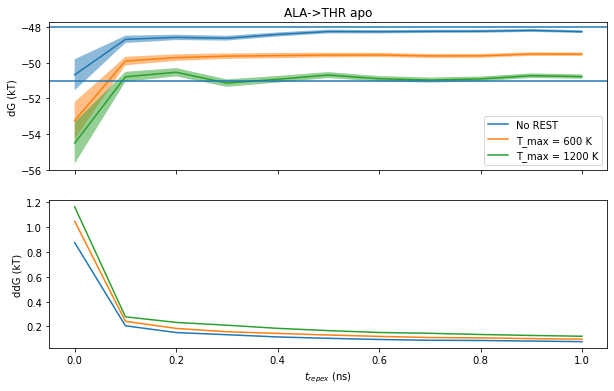

In [32]:
plot_series(d_results, 'apo', 'ALA->THR')

### Make plot with 3 experiments for each of n_replicas = 12, 24, 36

In [25]:
d_results = {}

for chunk in [11, 14, 15, 16, 17, 18, 19, 20, 21]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[chunk] = results

In [26]:
def plot_series(d_results, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,10), squeeze=True)
    colors = [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2]]*3
    linestyles = ['solid']*3 + ['dotted']*3 + ['dashed']*3
    labels = ['No REST (12)', 'T_max = 600 K (12)', 'T_max = 1200 K (12)', 
              'No REST (24)', 'T_max = 600 K (24)', 'T_max = 1200 K (24)',
              'No REST (36)', 'T_max = 600 K (36)', 'T_max = 1200 K (36)']
    for i, r in enumerate(list(d_results.keys())):
        dg_discarded = d_results[r][0]
        ddg_discarded = d_results[r][1]

        # dg
        ax = axes[0]
        x = np.array(range(len(dg_discarded)))/10 # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        y = dg_discarded
        ax.plot(x, y, label=f'{labels[i]}', color=colors[i], linestyle=linestyles[i])
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5, color=colors[i])

        # ddg
        ax = axes[1]
        x = np.array(range(len(ddg_discarded)))/10
        y = ddg_discarded
        ax.plot(x, y, color=colors[i], linestyle=linestyles[i])

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    axes[0].legend()
#     axes[0].axhline(y=-46.5)
#     axes[0].axhline(y=-50)
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/{chunk}_{phase}_series.png", dpi=500)
#     plt.clf()

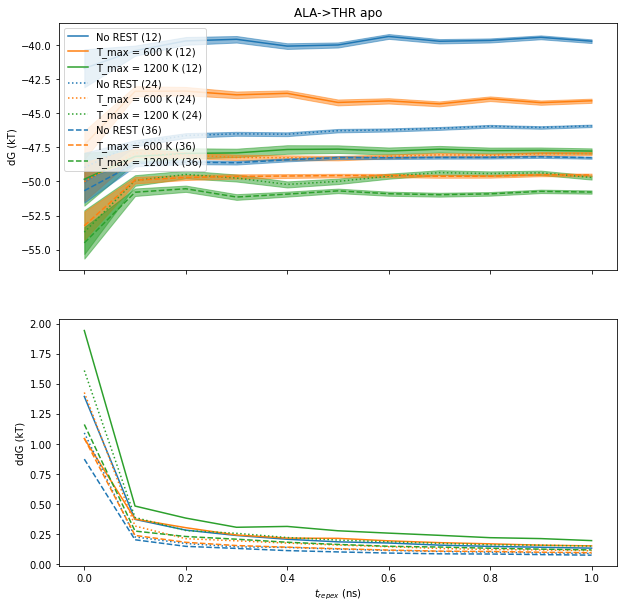

In [27]:
plot_series(d_results, 'apo', 'ALA->THR')